In [2]:
import pandas as pd
import os

def read_data_from_csv(path):
    """Load datasets from CSV files.
    Args:
        path (str): Path to the CSV file.
    Returns:
        X (np.ndarray): Features of samples.
        y (np.ndarray): Labels of samples, only provided in the public datasets.
    """
    assert os.path.exists(path), f'File not found: {path}!'
    assert os.path.splitext(path)[-1] == '.csv', f'Unsupported file type {os.path.splitext(path)[-1]}!'

    data = pd.read_csv(path)
    column_list = data.columns.values.tolist()

    if 'Label' in column_list:
        # for the public dataset, label column is provided.
        column_list.remove('Label')
        X = data[column_list].values
        y = data['Label'].astype('int').values
        return X, y
    else:
        # for the private dataset, label column is not provided.
        X = data[column_list].values
        return X
    

X_public, y_public = read_data_from_csv('assignment_5_public.csv')
print('Shape of X_public:', X_public.shape)  # n_sample, m_feature (30000, 58)
print('Shape of y_public:', y_public.shape)  # n_sample (30000,)


Shape of X_public: (30000, 58)
Shape of y_public: (30000,)


# Training the model and make predictions.
Here is the steps:
 1. Feature selection
 2. Feature scaling
 3. Training & cross-validation
 4. Parameter tuning
 5. Make predictions 



## which model should I use Decision Tree/K-Nearest Neighbor/Support Vector Machine ?

Decision Tree is easy to understand and analyze, no need for data preprocessing.
but it is easy to overfitting and not suitable for high dimensional data.
The current dataset has high dimensionality, and at the same time there are both continuous and discontinuous features in the features.
So Decision Tress is not applicable.

KNN does not require data preprocessing and is not applicable for high dimensional data,
So KNN is not applicable.

SVM is suitable for high latitude data and can handle both continuous and discontinuous features.
This dataset has high dimensionality, while there are both continuous and discontinuous features in the features.
Also this prediction result is a binary classification problem.
Therefore SVM model is chosen.
But SVM does not support missing data.

Within the dataset `Feature 18 Min. shares of worst keyword` has a large amount of missing data (data value is -1, i believe this represent the missing data).

Therefore, the columns of data should be removed during training.



# Feature selection

use correlation matrix select the features:
- remove the features that have a high correlation with each other.
- remove the features that have a low correlation with the label.

In [3]:
# Load the dataset
df = pd.read_csv('assignment_5_public.csv')

# Display the basic info and the first few rows of the dataframe
df.info(), df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 59 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Feature 1   30000 non-null  float64
 1   Feature 2   30000 non-null  float64
 2   Feature 3   30000 non-null  float64
 3   Feature 4   30000 non-null  float64
 4   Feature 5   30000 non-null  float64
 5   Feature 6   30000 non-null  float64
 6   Feature 7   30000 non-null  float64
 7   Feature 8   30000 non-null  float64
 8   Feature 9   30000 non-null  float64
 9   Feature 10  30000 non-null  float64
 10  Feature 11  30000 non-null  float64
 11  Feature 12  30000 non-null  float64
 12  Feature 13  30000 non-null  float64
 13  Feature 14  30000 non-null  float64
 14  Feature 15  30000 non-null  float64
 15  Feature 16  30000 non-null  float64
 16  Feature 17  30000 non-null  float64
 17  Feature 18  30000 non-null  float64
 18  Feature 19  30000 non-null  float64
 19  Feature 20  30000 non-nul

(None,
    Feature 1  Feature 2  Feature 3  Feature 4  Feature 5  Feature 6  \
 0        8.0      206.0   0.637306        1.0   0.702899       15.0   
 1        8.0      210.0   0.666667        1.0   0.868852        6.0   
 2        9.0      264.0   0.566265        1.0   0.668675        9.0   
 3        8.0      146.0   0.746479        1.0   0.941176        4.0   
 4       14.0     1267.0   0.398872        1.0   0.574099       39.0   
 
    Feature 7  Feature 8  Feature 9  Feature 10  ...  Feature 50  Feature 51  \
 0        2.0       11.0        1.0    4.699029  ...    0.166667         0.8   
 1        4.0        0.0        0.0    4.580952  ...    0.100000         0.5   
 2        4.0        1.0        0.0    4.719697  ...    0.136364         0.5   
 3        4.0        1.0        2.0    4.328767  ...    0.100000         0.6   
 4        7.0       11.0        0.0    4.719021  ...    0.033333         0.8   
 
    Feature 52  Feature 53  Feature 54  Feature 55  Feature 56  Feature 57  \

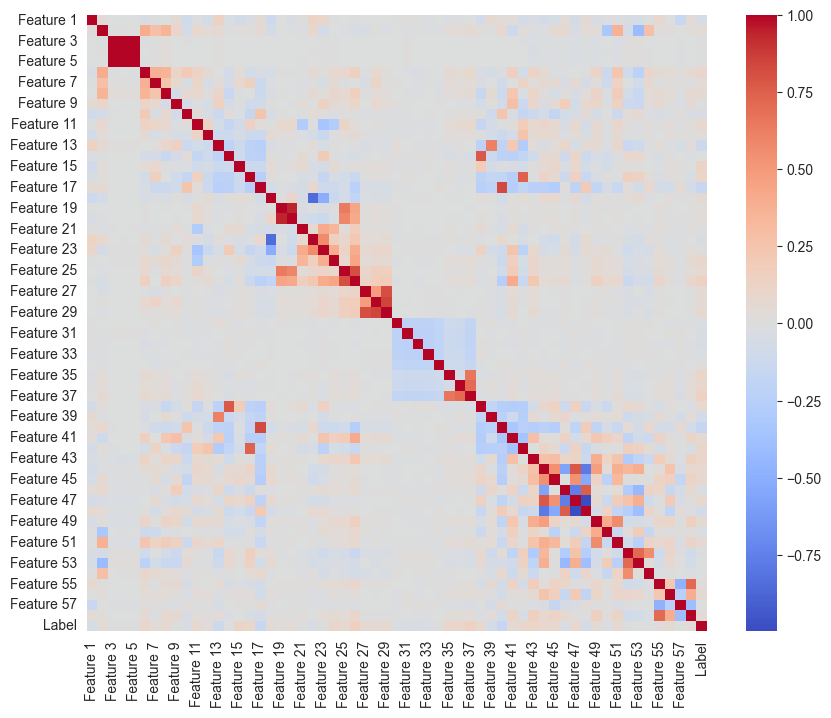

'correlation_heatmap.png'

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the correlation matrix
correlation_matrix = df.corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 8))

# Draw the heatmap
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt='.2f', ax=ax)

# Save the heatmap to a file
heatmap_path = 'correlation_heatmap.png'
plt.savefig(heatmap_path)

# Show the heatmap
plt.show()

heatmap_path


According to the correlation matrix:
- Feature 3,4,5,9,14,21,23,52,53,54,57 have low correlation (|x|<0.01) with the label.
- Feature 19,3,5,48 have high correlation with each other.

so the features 3,4,5,9,14,19,21,23,48,52,53,54,57 should be removed.
as well as the feature 18, because it has a large amount of missing data, as mentioned above.

# Data preprocessing & Data Scaling
- remove features 3,4,5,9,14,18,19,21,23,48,52,53,54,57
- standardize the continuous features ( mean = 0, variance = 1 )

In [5]:
from sklearn.preprocessing import StandardScaler
import numpy as np
def preprocessing(array):
    """Preprocess the data.
    Args:
        array (np.ndarray): Data to be preprocessed.
    Returns:
        array (np.ndarray): Preprocessed data.
    """
    # remove features 3,4,5,9,14,18,19,21,23,48,52,53,54,57
    array = np.delete(array, [2,3,4,8,13,17,18,20,22,47,51,52,53,56], axis=1)
    # standardize the continuous features
    # after the delete the index changed, now the continuous feature's indexes are 0,1,2,3,4,5,6,12,13,14,15,16,17,18,19,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43
    # 完美！
    columns_to_scale = [0,1,2,3,4,5,6,12,13,14,15,16,17,18,19,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43]
    scaler = StandardScaler()
    array[:,columns_to_scale] = scaler.fit_transform(array[:,columns_to_scale])
    return array

X_public_scaled = preprocessing(X_public)

preprocessing(X_public)

array([[-1.12898494, -0.75941078,  0.32941165, ...,  2.2096176 ,
         2.75283476,  2.85185039],
       [-1.12898494, -0.75086648, -0.45913659, ..., -0.86845351,
        -0.26416154, -0.68681989],
       [-0.65508613, -0.63551833, -0.19628718, ..., -0.86845351,
        -0.26416154, -0.68681989],
       ...,
       [-0.65508613, -0.50521764, -0.45913659, ..., -0.86845351,
        -0.26416154, -0.68681989],
       [ 0.2927115 ,  2.06448283,  1.55604224, ..., -0.48369462,
        -0.26416154, -0.68681989],
       [-0.18118731, -0.92816086, -0.72198601, ...,  0.8244856 ,
         1.05577434,  0.86134836]])

# Training & cross-validation & Parameter tuning

SVM normally has two parameters: kernel function and C value.
- kernel function: linear, polynomial, sigmoid, rbf
- C value: 0.01, 0.1, 1, 10, 100

Test different kernel functions and different C values.

using sigmoid as the kernel function:

In [6]:
# train the SVM model and cross-validation
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

svm_sigmoid = SVC(kernel='sigmoid', C=0.1, random_state=1)
scores = cross_val_score(estimator=svm_sigmoid, X=X_public_scaled, y=y_public, cv=5, n_jobs=1)

scores, np.mean(scores)

(array([0.586     , 0.59016667, 0.5885    , 0.58933333, 0.595     ]), 0.5898)

use rbf as the kernel function:

In [8]:
svm_rbf = SVC(kernel='rbf', C=1.0, random_state=1)
scores = cross_val_score(estimator=svm_rbf, X=X_public_scaled, y=y_public, cv=5, n_jobs=1)

scores, np.mean(scores)

(array([0.6635    , 0.66533333, 0.6585    , 0.65566667, 0.66783333]),
 0.6621666666666666)

use linear as the kernel function:

In [9]:
svm_linear = SVC(kernel='linear', C=1.0, random_state=1)
scores = cross_val_score(estimator=svm_linear, X=X_public_scaled, y=y_public, cv=5, n_jobs=1)

scores, np.mean(scores)

(array([0.65283333, 0.64716667, 0.64916667, 0.64383333, 0.65533333]),
 0.6496666666666666)

use polynomial as the kernel function:

In [10]:
svm_poly = SVC(kernel='poly', C=1.0, random_state=1)
scores = cross_val_score(estimator=svm_poly, X=X_public_scaled, y=y_public, cv=5, n_jobs=1)

scores, np.mean(scores)

(array([0.64883333, 0.65033333, 0.647     , 0.63833333, 0.64783333]),
 0.6464666666666667)

SVM's performance is not good, so I try to use other models.
KNN performance:

| n_neighbors | scores |
|-------------|--------|
| 3           | 0.5897 |
| 5           | 0.5979 |
| 7           | 0.6039 |
| 9           | 0.6103 |
| 11          | 0.6143 |
| 101         | 0.6343 |
| 1001        | 0.6272 |

In [11]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=101, p=2, metric='minkowski')
scores = cross_val_score(estimator=knn, X=X_public_scaled, y=y_public, cv=5, n_jobs=1)

scores, np.mean(scores)

(array([0.6365    , 0.63366667, 0.63466667, 0.62466667, 0.64183333]),
 0.6342666666666668)

the performance is not good as well, why this is happening?

Decision Tree:

In [12]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion='entropy', max_depth=10, random_state=1)
scores = cross_val_score(estimator=tree, X=X_public_scaled, y=y_public, cv=5, n_jobs=1)

scores, np.mean(scores)

(array([0.641     , 0.62783333, 0.62083333, 0.63633333, 0.63633333]),
 0.6324666666666666)

Neural Network:

In [7]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(100, 100, 100), activation='relu', solver='adam', max_iter=1000, random_state=1)

scores = cross_val_score(estimator=mlp, X=X_public_scaled, y=y_public, cv=5, n_jobs=1)

scores, np.mean(scores)

(array([0.5965    , 0.5925    , 0.58683333, 0.60783333, 0.60133333]), 0.597)

# Ensemble learning
choose svm_rbf, svm_linear, svm_poly, knn, tree as the base models.

In [14]:
from sklearn.ensemble import VotingClassifier

ensemble = VotingClassifier(estimators=[('svm_rbf', svm_rbf),('svm_linear', svm_linear),('svm_poly',svm_poly),('knn',knn),('tree',tree)], voting='hard')

# Make prediction

In [15]:
# standardize the continuous features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_public = scaler.fit_transform(X_public)
X_public = pd.DataFrame(X_public)
print(X_public[10])

X_private = read_data_from_csv('assignment_5_private.csv')
print('Shape of X_private:', X_private.shape)  # k_sample, m_feature (5000, 58)

import numpy as np

# fit data
ensemble.fit(X_public_scaled, y_public)

# evaluate the model
print('Accuracy:', ensemble.score(X_public_scaled, y_public))

0       -0.114033
1        0.408814
2        0.931660
3        0.931660
4        1.454507
           ...   
29995    0.408814
29996    0.931660
29997   -1.682572
29998    1.454507
29999   -0.636879
Name: 10, Length: 30000, dtype: float64
Shape of X_private: (5000, 58)
Accuracy: 0.6986


In [16]:
# remove and make your own predictions.
preds = ensemble.predict(preprocessing(X_private))
'''
CODE HERE!
e.g.,
preds = np.full(len(X_private), -1, dtype=int)
'''

submission = pd.DataFrame({'Label': preds})
submission.to_csv('assignment_5.csv', index=True, index_label='Id')